
#**Image colorization with OpenVINO™**

Colorizer model is a type of artificial intelligence model that is designed to automatically add colors to black and white images. This technology uses deep learning algorithms to analyze the content of the image and infer the most likely colors for each pixel based on its surrounding context. By doing so, colorizer models can quickly and accurately colorize large volumes of images, which can be useful in a variety of applications such as digital restoration of old photographs



 

A deep learning approach called "Colorful Colorization Network" (CCN), which takes a grayscale image as input and produces a colorized image as output. The CCN is trained using a large dataset of color images and their corresponding grayscale versions

For more details on this can be found [paper](https://arxiv.org/pdf/1603.08511.pdf) and [repository](https://github.com/richzhang/colorization)

This model is very usefull for Digital restoration of old photographs, Many old photographs only exist in grayscale, and colorization using traditional methods can be time-consuming and expensive. The deep learning approach proposed in this paper could provide a more efficient and cost-effective method for colorizing these photographs.

This tutorial demonstrates step by step instructions on how to run Colorizer with OpenVino

#1) Prerequisites

In [ ]:
!pip install onnx
!pip install onnxsim
!pip install onnxruntime
!pip install openvino
!pip install openvino-dev[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━

##Imports and Settings

In [ ]:
from PIL import Image
import numpy as np
from skimage import color
import torch
import torch.nn.functional as F
from IPython import embed
import colorizers
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Union

In [ ]:
MODEL_OUTPUT_DIR=Path("/content/")
BASE_MODEL_NAME='colorizer_model'

fp32_onnx_path = Path(MODEL_OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".onnx")
fp32_ir_path = fp32_onnx_path.with_suffix(".xml")
fp32_bin_path=fp32_onnx_path.with_suffix(".bin")



#2) Check model inference


##2.1) Get the Models


**Each conv layer refers to a block of 2 or 3 repeated
conv and ReLU layers, followed by a BatchNorm layer. The net has no pool layers.
All changes in resolution are achieved through spatial downsampling or upsampling
between conv blocks.**

![model struct](http://richzhang.github.io/colorization/resources/images/net_diagram.jpg)

In [ ]:
COLORIZER_ECCV16=colorizers.eccv16().eval()
COLORIZER_SIGGRAPH17 = colorizers.siggraph17().eval()

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


  0%|          | 0.00/123M [00:00<?, ?B/s]

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth" to /root/.cache/torch/hub/checkpoints/siggraph17-df00044c.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

##2.2) UTILS

**Th `preprocess_img` function is used to convert the RGB image to the Lab color space using the function color.rgb2lab**

The Lab color space, also known as CIELAB, is a color space that was designed to be more perceptually uniform than other color spaces such as RGB or CMYK. It is often used in color-related applications such as color correction, color matching, and image processing.

The Lab color space is composed of three channels: L, a, and b. 
1. The L channel represents the lightness or brightness of the color, with values ranging from 0 (black) to 100 (white). 
2. The a and b channels represent the color opponent dimensions of red-green and blue-yellow, respectively. 
3. The a channel ranges from -128 (green) to +127 (red), and the b channel ranges from -128 (blue) to +127 (yellow).

By separating the lightness and color information, the Lab color space allows for more accurate and consistent color reproduction across different devices and lighting conditions. It is often used as an intermediate color space in color-related workflows, and can be converted to and from other color spaces such as RGB, CMYK, and XYZ.



---

**The `postprocess_tens` function takes two PyTorch tensors as input**: 
*tens_orig_l* and *out_ab*. *tens_orig_l* is a tensor of size 1 x 1 x H_orig x W_orig containing the L channel of an original image. *out_ab* is a tensor of size 1 x 2 x H x W containing the predicted a and b color channels for the same image.

The function first checks the dimensions of the two input tensors to see if resizing is needed. If the dimensions of tens_orig_l and out_ab are the same, then no resizing is necessary. Otherwise, the function uses the F.interpolate function from the PyTorch library to resize out_ab to the same dimensions as tens_orig_l.

The function then concatenates tens_orig_l and out_ab along the channel dimension to create a 1 x 3 x H_orig x W_orig tensor in the Lab color space. The Lab tensor is converted to RGB using the color.lab2rgb function from the scikit-image package, and the resulting RGB image is returned as a numpy array of shape (H_orig, W_orig, 3).

The mode parameter is optional and specifies the interpolation mode to be used if resizing is necessary. The default mode is 'bilinear', which performs bilinear interpolation.

In [ ]:
def load_img(image_path: str) -> np.ndarray:
    """Load an image from a file path and return it as a numpy array.
    
    Args:
        image_path (str): The path to the image file.
        
    Returns:
        numpy.ndarray: The image as a numpy array.
    
    Raises:
        FileNotFoundError: If the file specified by image_path does not exist.
    """
    try:
        with Image.open(image_path) as img:
            out_np = np.asarray(img)
    except FileNotFoundError:
        raise FileNotFoundError(f"File '{image_path}' not found.")
		
    if out_np.ndim == 2:
        out_np = np.tile(out_np[:,:,None],3)
    return out_np

def resize_img(img: np.ndarray, HW: tuple[int, int] = (256, 256), resample: int = Image.BICUBIC) -> np.ndarray:
    """Resize an image to a specified height and width using a specified resampling method.
    
    Args:
        img (numpy.ndarray): The image to be resized.
        HW (tuple[int, int]): The desired height and width of the resized image. Defaults to (256, 256).
        resample (int): The resampling method to use. Can be one of:
            - Image.NEAREST (nearest-neighbor sampling)
            - Image.BOX (box sampling)
            - Image.BILINEAR (bilinear sampling)
            - Image.HAMMING (hamming-windowed sinc interpolation)
            - Image.BICUBIC (bicubic interpolation)
            - Image.LANCZOS (Lanczos-windowed sinc interpolation)
            Defaults to Image.BICUBIC.
        
    Returns:
        numpy.ndarray: The resized image as a numpy array.
    """
    pil_img = Image.fromarray(img)
    resized_img = pil_img.resize((HW[1], HW[0]), resample=resample)
    return np.asarray(resized_img)

def preprocess_img(img_rgb_orig: np.ndarray, HW: tuple[int, int] = (256, 256), resample: int = 3) -> tuple[torch.Tensor, torch.Tensor]:
	# return original size L and resized L as torch Tensors
	''' This function takes an input RGB image, resizes it to a specified height and width using the method resize_img, 
	converts the RGB image to the Lab color space using the function color.rgb2lab, 
	and returns two PyTorch tensors: one tensor containing the L channel of the original image, 
	and another tensor containing the L channel of the resized image.
	
	The HW parameter specifies the desired height and width of the resized image
	The resample parameter determines the resampling method used during the resizing process. 
	The default resampling method used is 3, which corresponds to the bicubic interpolation method. 

	    Args:
        img_rgb_orig (numpy.ndarray): The input RGB image.
        HW (tuple[int, int]): The desired height and width of the resized image. Defaults to (256, 256).
        resample (int): The resampling method to use during the resizing process. Can be one of:
            - 0 (nearest-neighbor sampling)
            - 1 (box sampling)
            - 2 (bilinear sampling)
            - 3 (bicubic interpolation)
            - 4 (hamming-windowed sinc interpolation)
            - 5 (Lanczos-windowed sinc interpolation)
            Defaults to 3.
        
    Returns:
        tuple[torch.Tensor, torch.Tensor]: A tuple containing two PyTorch tensors:
            - The L channel of the original image as a tensor with shape (1, 1, height, width).
            - The L channel of the resized image as a tensor with shape (1, 1, resized_height, resized_width).
    """'''

	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
	
	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

def postprocess_tens(tens_orig_l: torch.Tensor, out_ab: torch.Tensor, mode: str = 'bilinear') -> np.ndarray:
	"""Convert the output of a colorization model back to an RGB image.

	The color.lab2rgb function maps the Lab color values to their 
	corresponding RGB color values using a transformation that takes into 
	account the nonlinear nature of the Lab color space.
	 The output of color.lab2rgb is a numpy array of shape (H, W, 3) 
	 containing the RGB color image.

    Args:
        tens_orig_l (torch.Tensor): The L channel of the original image as a PyTorch tensor of shape (1, 1, height, width).
        out_ab (torch.Tensor): The predicted a and b channels of the colorized image as a PyTorch tensor of shape (1, 2, height, width).
        mode (str): The interpolation mode to use when resizing the predicted a and b channels to match the size of the original L channel. Can be one of:
            - 'nearest' (nearest-neighbor interpolation)
            - 'bilinear' (bilinear interpolation)
            - 'bicubic' (bicubic interpolation)
            - 'trilinear' (trilinear interpolation)
            - 'area' (pixel area resampling)
            Defaults to 'bilinear'.
        
    Returns:
        numpy.ndarray: An RGB image as a numpy array of shape (height, width, 3)."""
	HW = out_ab.shape[2:]
	HW_orig = tens_orig_l.shape[2:]

	if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
		out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
	else:
		out_ab_orig = out_ab

	out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
	return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))
 
def show_image(image):
	plt.imshow(image)
	return None

##3) Validate original model 

In order to showcase the remarkable capabilities of the algorithm for colorizing grayscale photos, we present a set of examples where the model performs exceptionally well in producing stunningly realistic colorizations. 

---



These examples offer a glimpse into the impressive range of colors and details that the algorithm can bring to otherwise dull and lifeless images. However, if you are interested in exploring the full potential of the model and would like to experiment with the code yourself, we encourage you to visit the website at http://richzhang.github.io/colorization/, where you can find a wealth of additional results and resources to help you get started.![](http://richzhang.github.io/colorization/resources/images/teaser3.jpg)

In [ ]:
sys.path.append('/content/drive/MyDrive/GSOC/openvino_notebooks-main/notebooks/utils')

In [ ]:
IMAGE_PATH='/content/drive/MyDrive/GSOC/colorization-master/imgs/ansel_adams.jpg'
IMAGE = load_img(IMAGE_PATH)
(tens_l_orig, tens_l_rs) = preprocess_img(IMAGE, HW=(256,256))

here it takes a grayscale image and applies the two pre-trained deep learning models, COLORIZER_ECCV16 and COLORIZER_SIGGRAPH17, to produce two colorized versions of the image, stored as numpy arrays in out_img_eccv16 and out_img_siggraph17. The postprocess_tens function is used to convert the model output to RGB color images.

In [ ]:
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, COLORIZER_ECCV16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, COLORIZER_SIGGRAPH17(tens_l_rs).cpu())

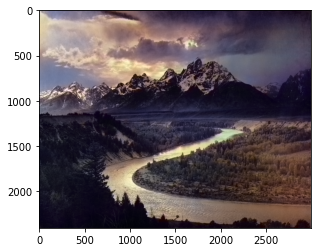

In [ ]:
show_image(out_img_eccv16)

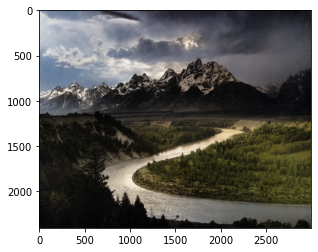

In [ ]:
show_image(out_img_siggraph17)

#4) Convert PyTorch model to ONNX

Converting a PyTorch model to the ONNX format enables the use of the model in a variety of production environments, such as web services and mobile applications. ONNX is an open format that allows interoperability between deep learning frameworks, making it a valuable tool for model portability. The convert_to_onnx function simplifies the process of converting PyTorch models to ONNX by creating a dummy input tensor, exporting the model using torch.onnx.export, and simplifying the resulting model using onnxsim. The resulting ONNX model can be used in a wide range of environments and provides a standardized way to represent deep learning models.

In [ ]:
import onnxsim
import onnx

In [ ]:
def convert_to_onnx(model: torch.nn.Module, output_path: str, input_shape: tuple = (256,256)):
    '''This function takes a PyTorch model and converts it to the ONNX format. 
    The resulting ONNX model is saved to the file specified by output_path.
    The input shape of the model is specified by input_shape, which is a tuple containing the height and width of the input image. 
    A dummy input tensor of size 1 x 1 x H x W is created using torch.randn.

    The ONNX conversion is performed using torch.onnx.export. The function takes the following arguments:

    model: the PyTorch model to convert
    dummy_input: a dummy input tensor used to trace the model
    output_path: the path where the resulting ONNX model will be saved
    verbose: a flag indicating whether to print verbose output during conversion
    keep_initializers_as_inputs: a flag indicating whether to treat initializer tensors as inputs
    opset_version: the ONNX opset version to use
    input_names: a list of input names for the model
    output_names: a list of output names for the model
    After the ONNX model is created, the function uses the onnxsim package to simplify the model. 
    The simplified model is then saved to output_path. If the simplification process fails, an error message is printed.

        Args:
        model (torch.nn.Module): The PyTorch model to convert.
        output_path (str): The path to save the resulting ONNX model.
        input_shape (tuple, optional): A tuple containing the height and width of the input image. 
            Defaults to (256, 256).

    Raises:
        Exception: If the ONNX simplification process fails.

    Returns:
        None
    '''

    dummy_input = torch.autograd.Variable(
        torch.randn(1, 1, input_shape[0], input_shape[1])
    )

    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        verbose=True,
        keep_initializers_as_inputs=True,
        opset_version=11,
        input_names=["data"],
        output_names=["output"],
    )
    input_data = {"data": dummy_input.detach().cpu().numpy()}
    model_sim, flag = onnxsim.simplify(output_path, input_data=input_data)
    if flag:
        onnx.save(model_sim, output_path)
    else:
        print("error")

In [ ]:
convert_to_onnx(COLORIZER_SIGGRAPH17, str(fp32_onnx_path))

#5) Convert ONNX Model to OpenVINO Intermediate Representation (IR)


The OpenVINO toolkit allows developers to optimize and deploy deep learning models on a variety of Intel hardware. To use an ONNX model with OpenVINO, the ONNX model must be converted to OpenVINO Intermediate Representation (IR) format. This process involves using the mo.py script provided by OpenVINO, which takes the ONNX model as input and generates an IR representation that can be executed on Intel hardware. The mo.py script performs optimizations such as weight quantization and layout transformations to improve model performance on Intel hardware. Once the ONNX model has been converted to IR format, it can be executed on a range of Intel devices, including CPUs, GPUs, and VPUs, using the OpenVINO inference engine. The ability to convert ONNX models to OpenVINO IR format provides a simple and effective way to optimize deep learning models for deployment on Intel hardware.

In [ ]:
from openvino.tools import mo
from openvino.runtime import serialize
from openvino.runtime import Model

In [ ]:
def create_bin_and_xml_files(onnx_model_path: Union[str, Path], ir_path: Union[str, Path]) -> None:
    '''
    Converts an ONNX model to the OpenVINO format and saves it as .xml and .bin files.

    Args:
        - onnx_model_path (Union[str, Path]): path to the ONNX model
        - ir_path (Union[str, Path]): path where the .xml and .bin files will be saved

    Returns: None
    '''
    
    onnx_model = mo.convert_model(str(onnx_model_path))
    serialize(model=onnx_model, xml_path=str(ir_path))

create_bin_and_xml_files(fp32_onnx_path, fp32_ir_path)


In [ ]:
from openvino.runtime import Core
core = Core()
model = core.read_model(fp32_ir_path)
compiled_model = core.compile_model(model, 'CPU')


In [ ]:
output_blob = compiled_model.output(0)
preds = (compiled_model(tens_l_rs)[output_blob])

#6) Validate converted model

In [ ]:
img = load_img(IMAGE_PATH)
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))

output_blob = compiled_model.output(0)
preds = (compiled_model(tens_l_rs)[output_blob])

out_img_eccv16 = postprocess_tens(tens_l_orig, torch.from_numpy(preds))
# out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

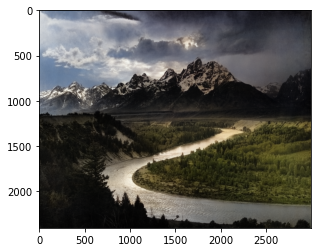

In [ ]:
show_image(out_img_eccv16)